In [ ]:
# Copyright (c) 2024, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

In [1]:
import os
import cv2
import json
import random
import orjson
from tqdm.auto import tqdm
import numpy as np
from collections import defaultdict, Counter
from matplotlib import pyplot as plt

from utils import seg_to_mask, PoissonDiskSampler

In [2]:
DATASET_PATH = '/home/ai2lab/work/datasets'

In [3]:
with open('/home/ai2lab/work/datasets/PACO/paco_lvis_v1_train.json') as f:
    data = json.load(f)
    
with open('refcoco_val_test_img_ids.json', 'r') as f:
    refcoco_val_test_img_ids = json.load(f)
refcoco_val_test_img_ids = set(refcoco_val_test_img_ids)

In [4]:
cat_dict = {c['id']: c for c in data['categories']}
ann_dict = defaultdict(list)
for ann in data['annotations']:
    ann_dict[ann['image_id']].append(ann)

In [5]:
train_img_ids = [ann['image_id'] for ann in data['annotations']]
len(set(train_img_ids) & refcoco_val_test_img_ids)

2926

In [6]:
sel_data = []
for img in tqdm(data['images']):
    img_id = img['id']
    img_area = img['width'] * img['height']
    image_path = f'COCO/train2017/{str(img_id).zfill(12)}.jpg'
    
    if img_id in refcoco_val_test_img_ids:
        continue
    
    anns = ann_dict[img_id]
    
    if len(anns) == 0:
        continue
    
    ann_by_class = defaultdict(list)
    for ann in anns:
        # skip not part objects
        if ann['id'] == ann['obj_ann_id']:
            continue

        ann_area = ann['bbox'][2] * ann['bbox'][3]
        ann['area_ratio'] = ann_area / img_area
        cat_id = ann['category_id']
        
        ann_by_class[cat_id].append(ann)
        
    for cat_id, objects in ann_by_class.items():
        if len(objects) > 5:
            continue
        if not all(bbox['area_ratio'] > 0.02 for bbox in objects):
            continue
        
        sel_data.append({
            'image_path': image_path,
            'img_width': img['width'],
            'img_height': img['height'],
            'obj_name': cat_dict[cat_id]['name'],
            'objects': objects,
        })

  0%|          | 0/45790 [00:00<?, ?it/s]

In [7]:
len(sel_data)

38345

In [12]:
# cal num unique image and object
img_counter = Counter()
obj_counter = Counter()
for d in sel_data:
    img_counter[d['image_path']] += 1
    for obj in d['objects']:
        obj_counter[obj['id']] += 1
len(img_counter), len(obj_counter)

(16805, 43321)

In [8]:
poisson_disk_sampler = PoissonDiskSampler(num_samples=100, radius=0.1)

In [9]:
all_ref_data = []
for d in tqdm(sel_data):
    try:
        image_path = d['image_path']
        img_w, img_h = d['img_width'], d['img_height']
        obj_name = d['obj_name']
        
        main_name, part_name = obj_name.split(':')
        obj_name = f'{part_name} of {main_name}'
        phrases = [obj_name]
        
        bboxes = []
        points_and_labels = []
        for obj in d['objects']:
            bbox = obj['bbox']
            bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            
            gt_mask = seg_to_mask(obj['segmentation'], img_h, img_w)
            
            scaled_bbox = [bbox[0]/img_w*1000, bbox[1]/img_h*1000, bbox[2]/img_w*1000, bbox[3]/img_h*1000]
            scaled_bbox = [int(round(x)) for x in scaled_bbox]
            scaled_bbox = [
                max(0, scaled_bbox[0]),
                max(0, scaled_bbox[1]),
                min(999, scaled_bbox[2]),
                min(999, scaled_bbox[3]),
            ]
            
            rand_points = poisson_disk_sampler.sample(bbox)
            rand_points = [(int(x), int(y)) for x, y in rand_points]
            on_masks = gt_mask[np.array(rand_points)[:, 1], np.array(rand_points)[:, 0]]
            
            scaled_rand_points = [(x/img_w*1000, y/img_h*1000) for x, y in rand_points]
            scaled_rand_points_on_mask = [(int(x), int(y), int(on_mask)) for (x, y), on_mask in zip(scaled_rand_points, on_masks)]
            
            bboxes.append(scaled_bbox)
            points_and_labels.append(scaled_rand_points_on_mask)
            
        assert len(bboxes) == len(points_and_labels)
        
        all_ref_data.append({
            'image_path': image_path,
            'phrases': phrases,
            'bboxes': bboxes,
            'points_and_labels': points_and_labels,
        })
    except Exception as e:
        # raise e
        print(f'Error')
        continue

  0%|          | 0/38345 [00:00<?, ?it/s]

In [10]:
# save with orjson
with open('processed_data_v2/paco_ref_data.json', 'w') as f:
    f.write(orjson.dumps(all_ref_data).decode())

['body of bowl']


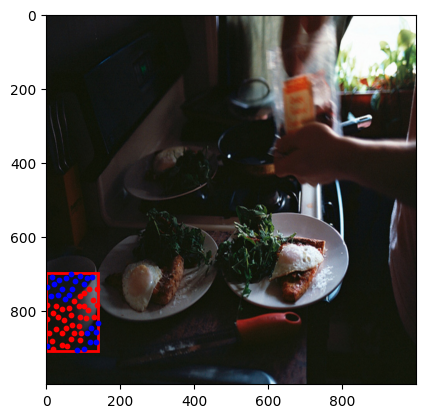

['bezel of cellular_telephone']


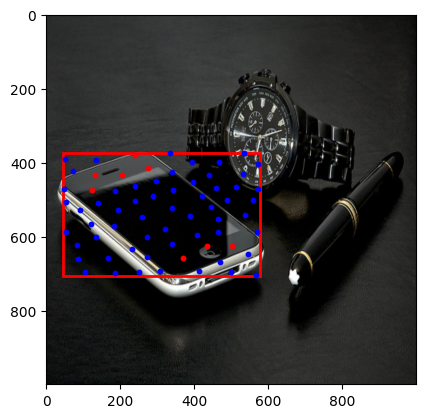

['inner_body of bowl']


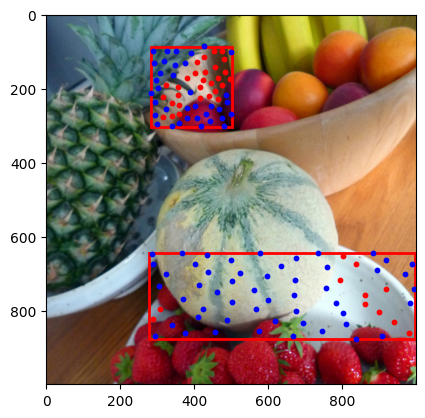

['finger_hole of scissors']


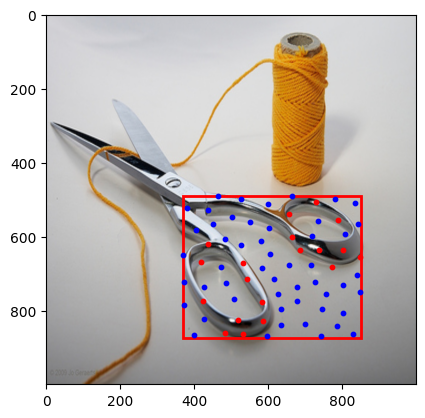

['back of chair']


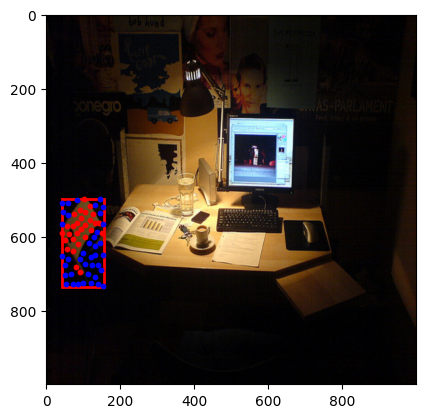

In [12]:
for d in random.sample(all_ref_data, 5):
    image_path = os.path.join(DATASET_PATH, d['image_path'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1000, 1000))
    bboxes = d['bboxes']
    points_and_labels = d['points_and_labels']

    print(d['phrases'])
    plt.imshow(image)
    for bbox in bboxes:
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=2))

    for points_and_labels_i in points_and_labels:
        for x, y, on_mask in points_and_labels_i:
            plt.scatter(x, y, c='red' if on_mask else 'blue', s=10)

    plt.show()